<a href="https://colab.research.google.com/github/BogdanTurbal/cnn_transformer_handwriting_recognition/blob/main/recognition_handwriting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import StringLookup
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import numpy as np
import os
import cv2
import skimage as sk
#import data_loader_cyrillic as dt
import pandas as pd
import copy
import string

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
class Preprocessor:
    def __init__(self, image_size, characters):
        (self.image_width, self.image_height) = image_size
        self.characters = characters
        self.padding_token = len(characters) + 1
        self.used = 0
       # print(f"padding token {self.padding_token}")

    def distortion_free_resize(self, image, img_size, vertical=False):
        w, h = img_size
        if vertical:
            image = tf.image.flip_left_right(image)
            image = tf.transpose(image, perm=[1, 0, 2])

        image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
        pad_height = h - tf.shape(image)[0]
        pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
        if pad_height % 2 != 0:
            height = pad_height // 2
            pad_height_top = height + 1
            pad_height_bottom = height
        else:
            pad_height_top = pad_height_bottom = pad_height // 2

        image = tf.pad(
            image,
            constant_values=255,
            paddings=[
            [pad_height_top, pad_height_bottom],
            [0, pad_width],
            [0, 0]]
            #mode="REFLECT"
            #[0, 0]

        )

        image = tf.transpose(image, perm=[1, 0, 2])
        image = tf.image.flip_left_right(image)
        return image
    def preprocess_image(self, image_path, label, vert=False):
        img_size=(self.image_width, self.image_height)
        #with open(image_path, "rb") as local_file: # <= change here
        #  image = local_file.read()
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, 1)
        vert = vert
        #if tf.get_static_value(tf.size(label)) > 3 and tf.shape(image)[0] > tf.shape(image)[1]:
        #    self.used += 1
        #    vert = True
        image = self.distortion_free_resize(image, img_size, vertical=vert)
        image = tf.cast(image, tf.float32) / 255.0
        return image


    def vectorize_label(self, label):
        label = self.char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
        ##
        length = tf.shape(label)[0]
        pad_amount = self.max_len - length
        label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=self.padding_token)
        ##
        return label


    def process_images_labels(self, image_path, label):
        image = self.preprocess_image(image_path, label)
        label = self.vectorize_label(label)
        return {"image": image, "label": label}

    def prepare_dataset(self, image_paths, labels, batch_size, char_to_num, max_len, vert=False):
        self.char_to_num = char_to_num
        #self.padding_token = self.char_to_num('|')
        self.max_len = max_len
        print(image_paths)
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
            self.process_images_labels, num_parallel_calls=AUTOTUNE
        )
        return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [10]:
class DataLoader:
    def __init__(self, img_dir, labels_path, image_size, batch_size = 64, characters=None, max_len = 32):
        self.base_image_path = self.base_path = img_dir
        self.batch_size = batch_size
        self.preprocessor = None
        self.image_size = image_size
        self.labels_path = labels_path
        self.characters = characters
        self.max_len = max_len

    def get_base_lines(self):
        words = pd.read_csv(self.labels_path, encoding = 'utf-8', sep='\t')
        #words = pd.concat([add_i(words), words], axis=0)
        words = words[words.label.apply(len) <= 32]
        #print(words)
        return words

    def get_image_paths_and_labels(self, samples):
        paths = []
        corrected_samples = []

        for i in range(samples.shape[0]):
            paths.append(self.base_path + '/' + samples['name'][i])
            corrected_samples.append(samples['label'][i])
        #print('00b05819.png' in c)
        return paths, corrected_samples

    def clean_labels(self, labels, metrics=False):
        cleaned_labels = []
        characters = set()
        max_len = 0
        for label in labels:
            label = label.replace('i', 'і').replace('c', 'с').replace('e', 'е').replace('o', 'о').replace('u', 'и').replace('r', 'ч').replace('I', 'І')
            if metrics:
                for char in label:
                    characters.add(char)
                max_len = max(max_len, len(label))
            cleaned_labels.append(label)
        if metrics:
            if '+' not in characters:
                characters.add('+')
            characters = sorted(list(characters))
            return cleaned_labels, characters, max_len
        else:
            return cleaned_labels


    def get_datasets(self):
        labels_df = self.get_base_lines()
        labels_df = labels_df.sample(frac = 1, random_state=42).reset_index(drop=True)
        print(labels_df)
        #return add_i(labels_df).image_path
        split_idx = int(0.9 * labels_df.shape[0])

        train_samples = labels_df.loc[:split_idx, :].reset_index(drop=True)
        test_samples = labels_df.loc[split_idx:, :].reset_index(drop=True)

        val_split_idx = int(0.3 * test_samples.shape[0])

        validation_samples = test_samples.loc[:val_split_idx, :].reset_index(drop=True)

        test_samples = test_samples.loc[val_split_idx:, :].reset_index(drop=True)
        print(f"train_size: {len(train_samples) + len(test_samples)}")
        print(f"valid_size: {len(validation_samples)}")

        train_img_paths, train_labels = self.get_image_paths_and_labels(train_samples)
        validation_img_paths, validation_labels = self.get_image_paths_and_labels(validation_samples)
        test_img_paths, test_labels = self.get_image_paths_and_labels(test_samples)

        del train_samples
        del validation_samples
        del test_samples
        train_labels_cleaned, characters, max_len = self.clean_labels(train_labels, metrics=True)
        if self.characters != None:
          characters = self.characters
        validation_labels_cleaned = self.clean_labels(validation_labels)
        test_labels_cleaned = self.clean_labels(test_labels)
        self.preprocessor = Preprocessor(self.image_size, characters)

        del train_labels
        del validation_labels
        del test_labels
        print(characters)
        # Mapping characters to integers.
        char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)
        # Mapping integers back to original characters.
        num_to_char = StringLookup(
            vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
        )
        #self.preprocessor.char_to_num = char_to_num
        #self.preprocessor.padding_token = padding_token

        train_ds = self.preprocessor.prepare_dataset(train_img_paths, train_labels_cleaned, self.batch_size, char_to_num, self.max_len)
        validation_ds = self.preprocessor.prepare_dataset(
            validation_img_paths, validation_labels_cleaned, self.batch_size, char_to_num, self.max_len)
        test_ds = self.preprocessor.prepare_dataset(test_img_paths, test_labels_cleaned, self.batch_size, char_to_num, self.max_len)

        return {'train_ds':train_ds, 'validation_ds': validation_ds,
                'test_ds':test_ds, "characters": characters,
                "num_to_char": num_to_char, "char_to_num": char_to_num,
               "max_len": max_len, "img_paths":train_img_paths + validation_img_paths+ test_img_paths}

In [11]:
base_path = '/content/drive/MyDrive/datasets/'

In [12]:
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive(base_path + 'dataset_med_100_v_1.rar').extractall("./")

In [13]:
image_width = 384
image_height = 64
path_data = '/content/dataset_med_100_v_1/data/'

In [14]:
#ch = [' ', '!', '"', '%', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'R', 'V', 'X', '[', ']', '`', 'b', 'h', 'p', 's', 't', 'x', 'y', '«', '»', 'ʼ', 'Є', 'І', 'Ї', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', 'є', 'і', 'ї', 'ґ', '№']

In [15]:
d_t = DataLoader(path_data, '/content/dataset_med_100_v_1/data.tsv', (image_width, image_height), batch_size=32, max_len = 32)
dict_dt = d_t.get_datasets()

       Unnamed: 0                  name             label
0            3085            ab2096.png                по
1           63280           yob3330.png        Российской
2           71351          yob18837.png         элементов
3           82517  585e2700eb60cc42.jpg                що
4           72734          test1444.png   Вас расторгнуть
...           ...                   ...               ...
98028        6265            ae1801.png            сигнал
98029       54889            rc5271.png  Петренко Нателья
98030       76828  f9c837dee90f400e.jpg      українського
98031         860            aa2705.png    другие монеты.
98032       15795            as7882.png           Мищенко

[98033 rows x 3 columns]
train_size: 95093
valid_size: 2942
[' ', '!', '"', '%', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'R', 'V', 'X', '[', ']', '`', 'b', 'h', 'p', 's', 't', 'x', 'y', '«', '»', 'ʼ', 'Є', 'І', 'Ї', 'А', 'Б', 'В', 'Г

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['/content/dataset_med_100_v_1/data//dem30939.png', '/content/dataset_med_100_v_1/data//rc4912.png', '/content/dataset_med_100_v_1/data//aq676.png', '/content/dataset_med_100_v_1/data//ag4072.png', '/content/dataset_med_100_v_1/data//pe6787.png', '/content/dataset_med_100_v_1/data//dbx1801.png', '/content/dataset_med_100_v_1/data//f4a7b05c67dd3028.jpg', '/content/dataset_med_100_v_1/data//yob13413.png', '/content/dataset_med_100_v_1/data//as15578.png', '/content/dataset_med_100_v_1/data//9ba317741ade1efc.jpg', '/content/dataset_med_100_v_1/data//yob16391.png', '/content/dataset_med_100_v_1/data//yob13057.png', '/content/dataset_med_100_v_1/data//af166.png', '/content/dataset_med_100_v_1/data//676f801d3be976e9.jpg', '/content/dataset_med_100_v_1/data//ao10585.png', '/content/dataset_med_100_v_1/data//yob10871.png', '/content/dataset_med_100_v_1/data//aa846.png', '/content/dataset_med_100_v_1/data//802410525c7f65d8.jpg', '/content/dataset_med_100_v_1/data//a56425c1db164d79.jpg', '/conten

In [17]:
train_ds = dict_dt['train_ds']
validation_ds = dict_dt['validation_ds']
test_ds = dict_dt['test_ds']
num_to_char = dict_dt['num_to_char']
char_to_num = dict_dt['char_to_num']
characters = dict_dt['characters']
max_len = 48
unt_ds = train_ds.concatenate(test_ds)

In [18]:
len(list(characters))

112

In [22]:
# d_t2 = DataLoader(path_data, '/content/dataset_med_100_v_1/data.tsv', (image_width, image_height), batch_size=32, max_len = 48)
# dict_dt2 = d_t2.get_datasets()

In [23]:
# train_ds2 = dict_dt2['train_ds']
# validation_ds2 = dict_dt2['validation_ds']
# test_ds2 = dict_dt2['test_ds']
# characters = dict_dt2['characters']
# num_to_char = dict_dt2['num_to_char']
# char_to_num = dict_dt2['char_to_num']

In [24]:
num_of_characters = len(list(characters))
print(num_of_characters)
padding_token = num_of_characters + 1
print(padding_token)

112
113


In [25]:
img_paths = dict_dt['img_paths']

In [ ]:
#print(characters)

In [26]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [27]:
for i in range(1):
    print("".join(list(map(lambda x: x.decode("UTF-8"), num_to_char(validation_labels[0][i]).numpy()))))
    print(" ".join(list(map(lambda x: str(x), validation_labels[0][i].numpy()))))

реждения[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]
91 80 81 79 80 88 83 106 113 113 113 113 113 113 113 113 113 113 113 113 113 113 113 113 113 113 113 113 113 113 113 113


In [28]:
def transf(img):
  img = tf.image.flip_left_right(img)
  img = tf.transpose(img, perm=[1, 0, 2])
  img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
  img = img[:, :, 0]
  return img

In [29]:
trans = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.015),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomContrast(0.2),
    #tf.keras.layers.RandomBrightness(0.02),
    layers.Resizing(256, 64)]
)

In [30]:
# for data in train_ds.take(10):
#   images, labels = data["image"], data["label"]
#   label = tf.strings.reduce_join(num_to_char(labels[0]))
#   label = label.numpy().decode("utf-8")
#   print(label)

In [31]:
# for data in validation_ds.take(10):
#     images, labels = data["image"], data["label"]

#     _, ax = plt.subplots(4, 2, figsize=(15, 15))
#     #x = tf.keras.layers.RandomRotation(0.013)(images)
#     #x = tf.keras.layers.RandomTranslation(0.1, 0.1)(x)
#     #x = tf.keras.layers.RandomZoom(0.1, 0.1)(x)
#     #x = tf.keras.layers.RandomHeight(0.2)(x)
#     #x = tf.keras.layers.RandomHeight(0.2)(x)
#     #x = tf.keras.layers.RandomContrast(0.1)(x)
#     #x = RandomBrightness(max_delta=0.2)(x)
#     #x = tf.keras.layers.RandomBrightness(0.2)(x)
#     #x = DistortionFreeResize(256, 64)(x)
#     #images = x
#     #lr6 = tf.keras.layers.RandomBrightness(0.2)
#     for i in range(4):
#         img = images[i]
#         img_ = copy.deepcopy(img)
#         #img = trans(img)
#         img = tf.image.flip_left_right(img)
#         img = tf.transpose(img, perm=[1, 0, 2])
#         img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)

#         img_ = tf.image.flip_left_right(img_)
#         img_ = tf.transpose(img_, perm=[1, 0, 2])
#         img_ = (img_ * 255.0).numpy().clip(0, 255).astype(np.uint8)

#         img = img[:, :, 0]
#         img_ = img_[:, :, 0]

#         # Gather indices where label!= padding_token.
#         label = labels[i]
#         indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
#         # Convert to string.
#         label = tf.strings.reduce_join(num_to_char(indices))
#         label = label.numpy().decode("utf-8")

#         ax[i, 0].imshow(img, cmap="gray")
#         ax[i, 0].set_title(label)
#         ax[i, 0].axis("off")

#         ax[i, 1].imshow(img_, cmap="gray")
#         ax[i, 1].set_title(label)
#         ax[i, 1].axis("off")
# plt.show()

In [32]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [33]:
@tf.function
def max_pooling(input, image_height=image_height):
    res = layers.MaxPool2D(pool_size=(1, image_height), padding='valid')(input)
    res = tf.squeeze(res, axis = 2)
    return res

In [34]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen = maxlen

    def call(self, x):
        positions = tf.range(start=0, limit=self.maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

In [35]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
            layers.Dropout(rate)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # layer norm

In [36]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [37]:
def get_transformer_model(image_width=image_width, image_height=image_height):
    rate_d = 0.25
    input_imgs = layers.Input(name="image", shape=(image_width, image_height, 1,))
    labels = layers.Input(name="label", shape=(None,))
    x = layers.Conv2D(64, 3, padding='same')(input_imgs)
    x = layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2),padding='same')(x)
    x = keras.layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2),padding='same')(x)
    x = keras.layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2), padding='same')(x)
    x = keras.layers.Dropout(rate_d)(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(3, 1), strides=(3, 1), padding='same')(x)
    x = keras.layers.Dropout(rate_d)(x)

    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(x)
    x = keras.layers.Dropout(rate_d)(x)

    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(1, 4), strides=(1, 4),padding='same')(x)
    x = keras.layers.Dropout(rate_d)(x)

    dim = 256
    new_shape = ((image_width // 12), (256))
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = TokenAndPositionEmbedding(maxlen=(image_width // 12), vocab_size=num_of_characters + 2, embed_dim=256)(x)

    x = TransformerBlock(256, 4, 512, rate=0.1)(x)
    x = TransformerBlock(256, 4, 256, rate=0.1)(x)

    x = layers.Dense(num_of_characters + 2, activation='softmax', name='end_dense')(x)
    output = CTCLayer(name="ctc_loss")(labels, x)


    model = tf.keras.models.Model(
        inputs=[input_imgs, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    return model

In [ ]:
# def get_transformer_model_leg(image_width=image_width, image_height=image_height):
#     rate_d = 0.25
#     input_imgs = layers.Input(name="image", shape=(image_width, image_height, 1,))
#     labels = layers.Input(name="label", shape=(None,))
#     x = layers.Conv2D(64, 3, padding='same')(input_imgs)
#     x = layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2),padding='same')(x)
#     x = keras.layers.Dropout(0.2)(x)

#     x = layers.Conv2D(64, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2),padding='same')(x)
#     x = keras.layers.Dropout(0.2)(x)

#     x = layers.Conv2D(128, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
#     x = keras.layers.Dropout(rate_d)(x)

#     x = layers.Conv2D(128, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = keras.layers.Dropout(rate_d)(x)

#     x = layers.Conv2D(256, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(x)
#     x = keras.layers.Dropout(rate_d)(x)

#     x = layers.Conv2D(256, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = layers.MaxPool2D(pool_size=(1, 4), strides=(1, 4),padding='same')(x)
#     x = keras.layers.Dropout(rate_d)(x)

#     dim = 256
#     new_shape = ((image_width // 8), (256))
#     x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
#     x = TokenAndPositionEmbedding(maxlen=(image_width // 8), vocab_size=num_of_characters + 2, embed_dim=256)(x)

#     x = TransformerBlock(256, 4, 512, rate=0.1)(x)
#     x = TransformerBlock(256, 4, 256, rate=0.1)(x)

#     x = layers.Dense(num_of_characters + 2, activation='softmax', name='end_dense')(x)
#     output = CTCLayer(name="ctc_loss")(labels, x)


#     model = tf.keras.models.Model(
#         inputs=[input_imgs, labels], outputs=output, name="handwriting_recognizer"
#     )
#     # Optimizer.
#     return model

In [38]:
# def get_model(image_width=image_width, image_height=image_height):
#     rate_d = 0.3
#     input_imgs = layers.Input(name="image", shape=(image_width, image_height, 1,))
#     labels = layers.Input(name="label", shape=(None,))
#     x = layers.Conv2D(32, 3, padding='same')(input_imgs)
#     x = layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
#     x = keras.layers.Dropout(0.2)(x)

#     x = layers.Conv2D(64, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2),padding='same')(x)
#     x = keras.layers.Dropout(0.2)(x)

#     x = layers.Conv2D(128, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)

#     x = keras.layers.Dropout(rate_d)(x)

#     x = layers.Conv2D(128, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = layers.MaxPool2D(pool_size=(3, 2), strides=(3, 2),padding='same')(x)
#     x = keras.layers.Dropout(rate_d)(x)

#     x = layers.Conv2D(256, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(x)
#     x = keras.layers.Dropout(rate_d)(x)

#     x = layers.Conv2D(256, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = layers.MaxPool2D(pool_size=(1, 4), strides=(1, 4),padding='same')(x)
#     x = keras.layers.Dropout(rate_d)(x)

#     dim = 128
#     new_shape = ((image_width // 8), (256))
#     x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
#     x = keras.layers.Bidirectional(
#         keras.layers.LSTM(256, return_sequences=True, dropout=0.25)
#     )(x)
#     x = keras.layers.Bidirectional(
#         keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
#     )(x)
#     x = layers.Dense(num_of_characters + 2, activation='softmax', name='end_dense')(x)
#     output = CTCLayer(name="ctc_loss")(labels, x)


#     model = tf.keras.models.Model(
#         inputs=[input_imgs, labels], outputs=output, name="handwriting_recognizer"
#     )
#     # Optimizer.
#     return model

In [39]:
# transformer_l = get_transformer_model_leg()
# transformer_l.load_weights('/content/drive/MyDrive/ml/trainin_wide_new/cp-0038.ckpt')
# learning_rate = CustomSchedule(256)
# opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
#                                      epsilon=1e-9)
#     #opt = keras.optimizers.Adam()
#     # Compile the model and return.
# transformer_l.compile(optimizer=opt)
# transformer_l.summary()

In [41]:
transformer = get_transformer_model()
#transformer.load_weights('/content/drive/MyDrive/ml/trainin_wide_new/cp-0038.ckpt')
# for i in range(len(transformer.layers)):
#   if i == 32 or i == 18:
#     continue
#   j = i
#   if i >=18:
#     j -= 1
#   transformer.layers[i].set_weights(transformer_l.layers[j].get_weights())
learning_rate = CustomSchedule(256)
opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
    #opt = keras.optimizers.Adam()
    # Compile the model and return.
transformer.compile(optimizer=opt)
transformer.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 384, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 384, 64, 64)  640         ['image[0][0]']                  
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 384, 64, 64)  256        ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                                                             

In [42]:
# model = get_model()
# model.load_weights('/content/drive/MyDrive/ml/lstm_model_wide_v1/cp-0016.ckpt')
# opt = keras.optimizers.Adam()
#     # Compile the model and return.
# model.compile(optimizer=opt)
# model.summary()

In [43]:
def calculate_edit_distance(labels, predictions, max_len = 32):
    # Get a single batch and convert its labels to sparse tensors.
    global_lens = tf.map_fn(fn=lambda tn: len(tf.where(tn != padding_token)), elems=labels)
    global_len = tf.math.reduce_sum(global_lens).numpy()

    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = tf.keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    np_decod = predictions_decoded.numpy()
    np_decod[np.where(np_decod == -1)] = padding_token
    predictions_decoded = tf.Variable(np_decod)

    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )

    return tf.math.reduce_sum(edit_distances).numpy() / global_len

class EditDistanceCallback(tf.keras.callbacks.Callback):
    def __init__(self, pred_model, dataset_img, dataset_lbl, max_len):
        super().__init__()
        self.prediction_model = pred_model
        self.dataset_img = dataset_img
        self.dataset_lbl = dataset_lbl
        self.max_len = max_len

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []
        rgs, gls = 0, 0
        for i in range(len(self.dataset_img)):
            labels = self.dataset_lbl[i]
            predictions = self.prediction_model.predict(self.dataset_img[i], verbose=0)
            edd = calculate_edit_distance(labels, predictions, max_len = self.max_len)
            edit_distances.append(edd)

        print(
            f"\n Mean cer for epoch {epoch + 1}: {np.mean(edit_distances):.4f} \n"
        )

In [44]:
prediction_model = tf.keras.models.Model(
    transformer.get_layer(name="image").input, transformer.get_layer(name="end_dense").output
  )
ds = train_ds.concatenate(test_ds)
edit_distance_callback = EditDistanceCallback(prediction_model, validation_images, validation_labels, max_len=32)

In [45]:
checkpoint_path = "/content/drive/MyDrive/ml/trans_model_wide_v3/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_freq=3*batch_size)

In [46]:
# model.fit(ds,
#                 epochs=40,
#                 validation_data=validation_ds,
#                 callbacks = [cp_callback, edit_distance_callback])

In [ ]:
transformer.fit(ds,
          epochs=45,
          initial_epoch=25,
          validation_data=validation_ds,
          callbacks = [cp_callback, edit_distance_callback])

Epoch 26/45
2965/2965 [==============================] - ETA: 0s - loss: 3.5301 Mean cer for epoch 26: 0.0792 
 CER 26: 0.0796
2965/2965 [==============================] - 402s 128ms/step - loss: 3.5301 - val_loss: 1.6348
Epoch 27/45
2965/2965 [==============================] - ETA: 0s - loss: 3.4560 Mean cer for epoch 27: 0.0857 
 CER 27: 0.0859
2965/2965 [==============================] - 365s 123ms/step - loss: 3.4560 - val_loss: 1.7751
Epoch 28/45
2965/2965 [==============================] - ETA: 0s - loss: 3.4049 Mean cer for epoch 28: 0.0847 
 CER 28: 0.0850
2965/2965 [==============================] - 363s 122ms/step - loss: 3.4049 - val_loss: 1.7613
Epoch 29/45
2965/2965 [==============================] - ETA: 0s - loss: 3.3804 Mean cer for epoch 29: 0.0830 
 CER 29: 0.0833
2965/2965 [==============================] - 362s 122ms/step - loss: 3.3804 - val_loss: 1.7735
Epoch 30/45
2965/2965 [==============================] - ETA: 0s - loss: 3.3454 Mean cer for epoch 30: 0.0883 
 

KeyboardInterrupt: ignored

In [ ]:
transformer.fit(ds,
          epochs=45,
          initial_epoch=25,
          validation_data=validation_ds,
          callbacks = [cp_callback, edit_distance_callback])

Epoch 26/45
2965/2965 [==============================] - ETA: 0s - loss: 7.2827
 Mean cer for epoch 26: 0.1807 

2965/2965 [==============================] - 370s 121ms/step - loss: 7.2827 - val_loss: 4.0419
Epoch 27/45
2965/2965 [==============================] - ETA: 0s - loss: 5.6667
 Mean cer for epoch 27: 0.1887 

2965/2965 [==============================] - 355s 120ms/step - loss: 5.6667 - val_loss: 4.2073
Epoch 28/45
2965/2965 [==============================] - ETA: 0s - loss: 5.0860
 Mean cer for epoch 28: 0.1674 

2965/2965 [==============================] - 355s 120ms/step - loss: 5.0860 - val_loss: 3.8039
Epoch 29/45
2965/2965 [==============================] - ETA: 0s - loss: 4.6794
 Mean cer for epoch 29: 0.1548 

2965/2965 [==============================] - 355s 120ms/step - loss: 4.6794 - val_loss: 3.6198
Epoch 30/45
2965/2965 [==============================] - ETA: 0s - loss: 4.3988
 Mean cer for epoch 30: 0.1596 

2965/2965 [==============================] - 354s 119ms

KeyboardInterrupt: ignored

In [ ]:
transformer.fit(ds,
                epochs=40,
                validation_data=validation_ds,
                callbacks = [cp_callback, edit_distance_callback])

Epoch 1/40
2967/2967 [==============================] - ETA: 0s - loss: 20.5051 Mean cer for epoch 1: 2.5225
 CER 1: 2.5048
2967/2967 [==============================] - 404s 132ms/step - loss: 20.5051 - val_loss: 9.1914
Epoch 2/40
2966/2967 [============================>.] - ETA: 0s - loss: 9.0124 Mean cer for epoch 2: 2.4571
 CER 2: 2.4396
2967/2967 [==============================] - 370s 125ms/step - loss: 9.0124 - val_loss: 6.9772
Epoch 3/40
2966/2967 [============================>.] - ETA: 0s - loss: 6.8440 Mean cer for epoch 3: 2.4028
 CER 3: 2.3855
2967/2967 [==============================] - 366s 123ms/step - loss: 6.8440 - val_loss: 4.9841
Epoch 4/40
2966/2967 [============================>.] - ETA: 0s - loss: 5.8973 Mean cer for epoch 4: 2.3724
 CER 4: 2.3551
2967/2967 [==============================] - 366s 123ms/step - loss: 5.8973 - val_loss: 4.8097
Epoch 5/40
2966/2967 [============================>.] - ETA: 0s - loss: 5.3183 Mean cer for epoch 5: 2.3701
 CER 5: 2.3528
296

KeyboardInterrupt: ignored

In [ ]:
transformer.fit(ds,
                initial_epoch=15,
                epochs=40,
                validation_data=validation_ds,
                callbacks = [cp_callback, edit_distance_callback])

Epoch 16/40
2973/2973 [==============================] - ETA: 0s - loss: 3.4551 Mean cer for epoch 16: 0.1132 
 CER 16: 0.1131
2973/2973 [==============================] - 425s 139ms/step - loss: 3.4551 - val_loss: 2.3919
Epoch 17/40
2973/2973 [==============================] - ETA: 0s - loss: 3.3575 Mean cer for epoch 17: 0.1163 
 CER 17: 0.1162
2973/2973 [==============================] - 363s 122ms/step - loss: 3.3575 - val_loss: 2.5271
Epoch 18/40
2973/2973 [==============================] - ETA: 0s - loss: 3.2861 Mean cer for epoch 18: 0.1170 
 CER 18: 0.1169
2973/2973 [==============================] - 363s 122ms/step - loss: 3.2861 - val_loss: 2.4955
Epoch 19/40
2973/2973 [==============================] - ETA: 0s - loss: 3.2080 Mean cer for epoch 19: 0.1101 
 CER 19: 0.1101
2973/2973 [==============================] - 363s 122ms/step - loss: 3.2080 - val_loss: 2.3693
Epoch 20/40
2973/2973 [==============================] - ETA: 0s - loss: 3.1617 Mean cer for epoch 20: 0.1123 
 

KeyboardInterrupt: ignored

In [47]:
# import os
# import shutil

# def copy_files(src_dir, dest_dir):
#     # Ensure destination directory exists
#     if not os.path.exists(dest_dir):
#         os.makedirs(dest_dir)

#     # Iterate through all files in the source directory
#     for file_name in os.listdir(src_dir):
#         # Create absolute paths for source and destination files
#         src_file_path = os.path.join(src_dir, file_name)
#         dest_file_path = os.path.join(dest_dir, file_name)

#         # Check if the item is a file (not a directory) and copy it
#         if os.path.isfile(src_file_path):
#             shutil.copy2(src_file_path, dest_file_path)
#         elif os.path.isdir(src_file_path):
#             # If the item is a directory, create a new destination directory and copy its contents recursively
#             new_dest_dir = os.path.join(dest_dir, file_name)
#             copy_files(src_file_path, new_dest_dir)

# # Example usage:
# source_directory = "/content/training/"
# destination_directory = "/content/drive/MyDrive/project/trans_mod/"
# copy_files(source_directory, destination_directory)
# model.save_weights("/content/drive/MyDrive/project/trans_mod/last_model.h5")

1/1 [==============================] - 0s 22ms/step


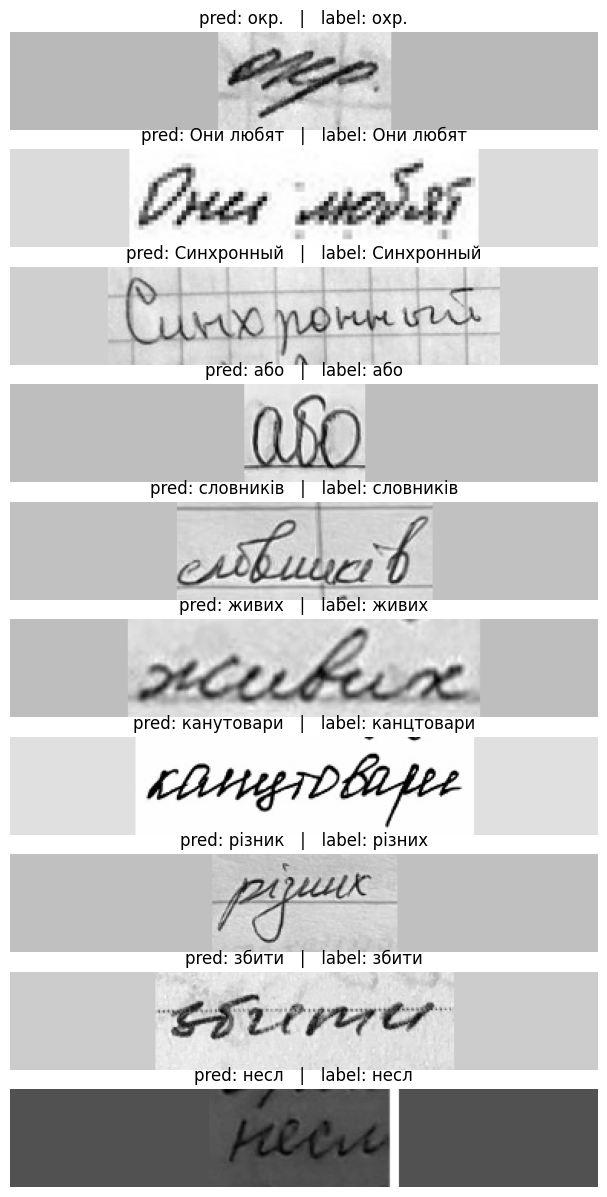

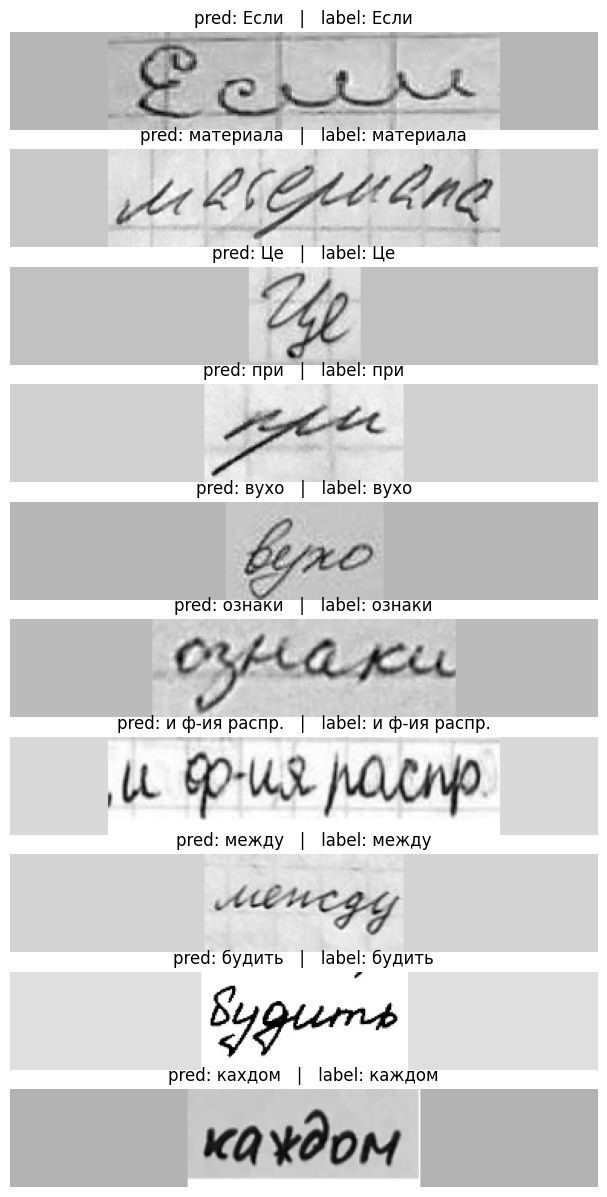

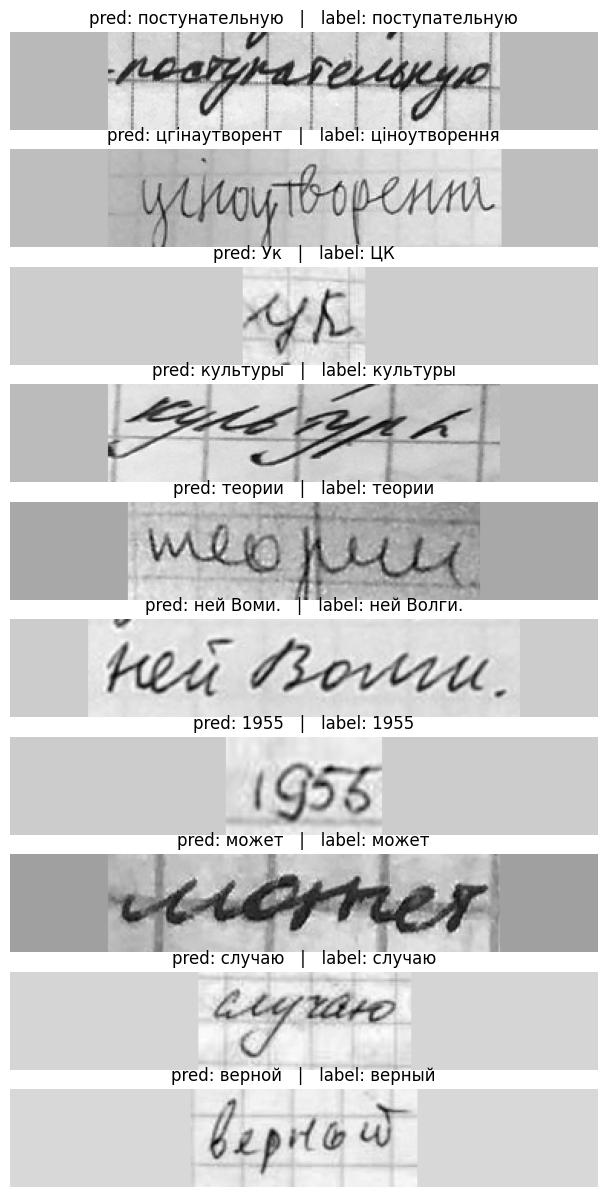

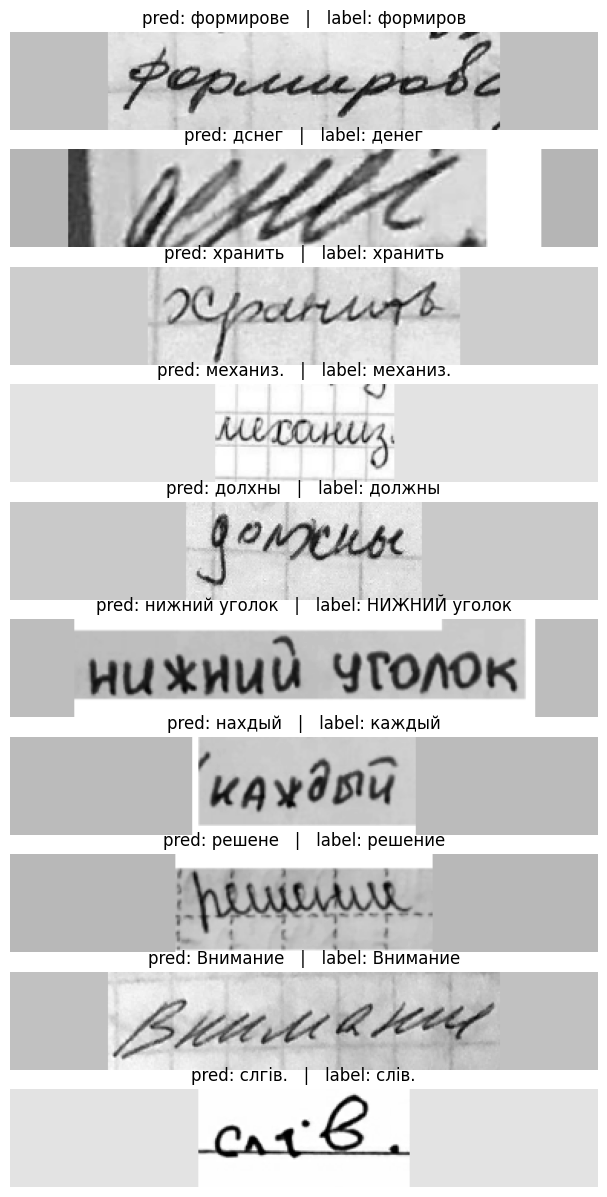

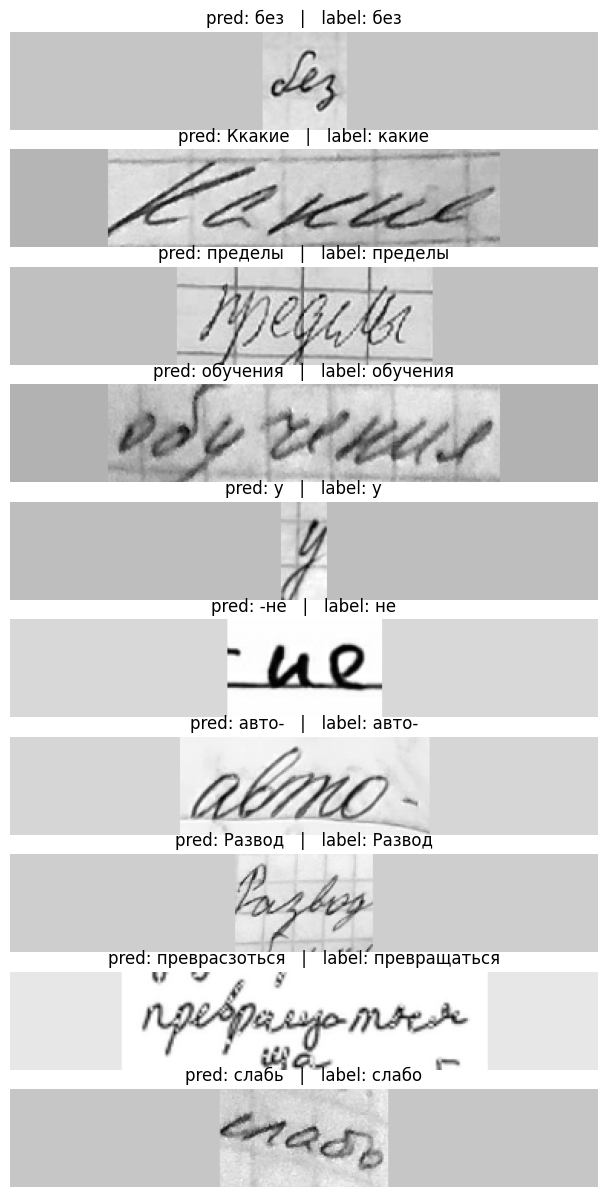

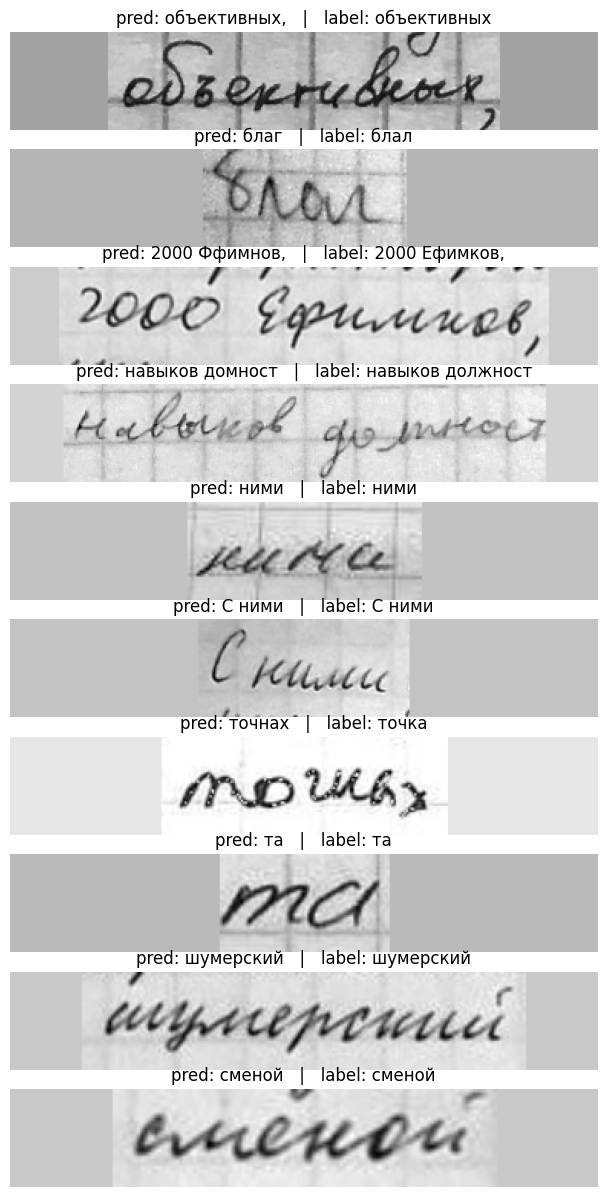

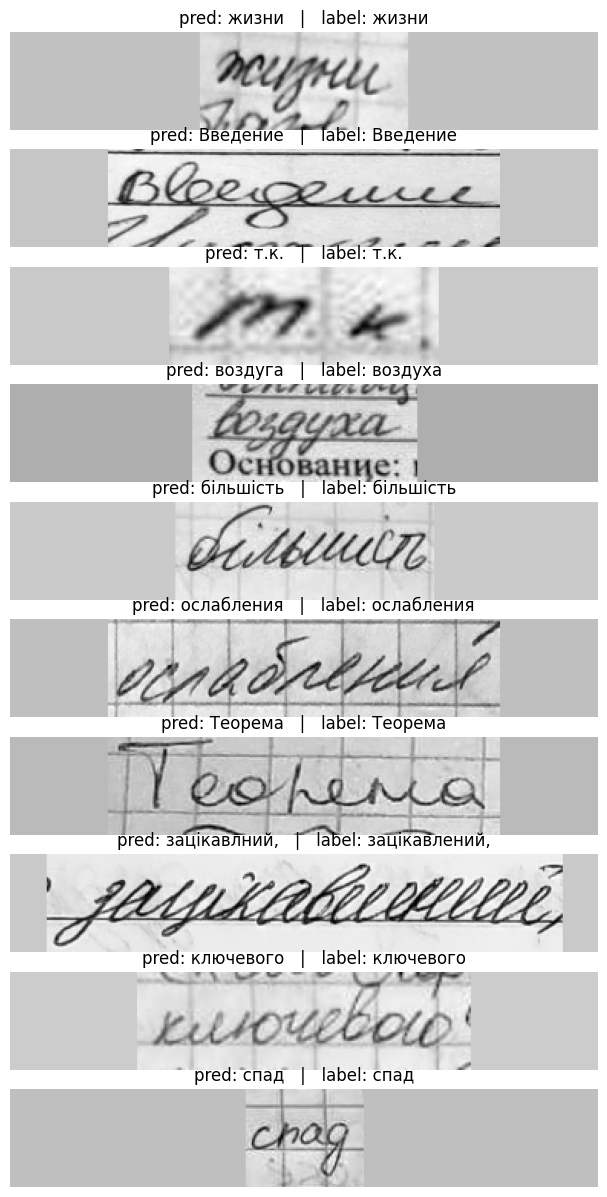

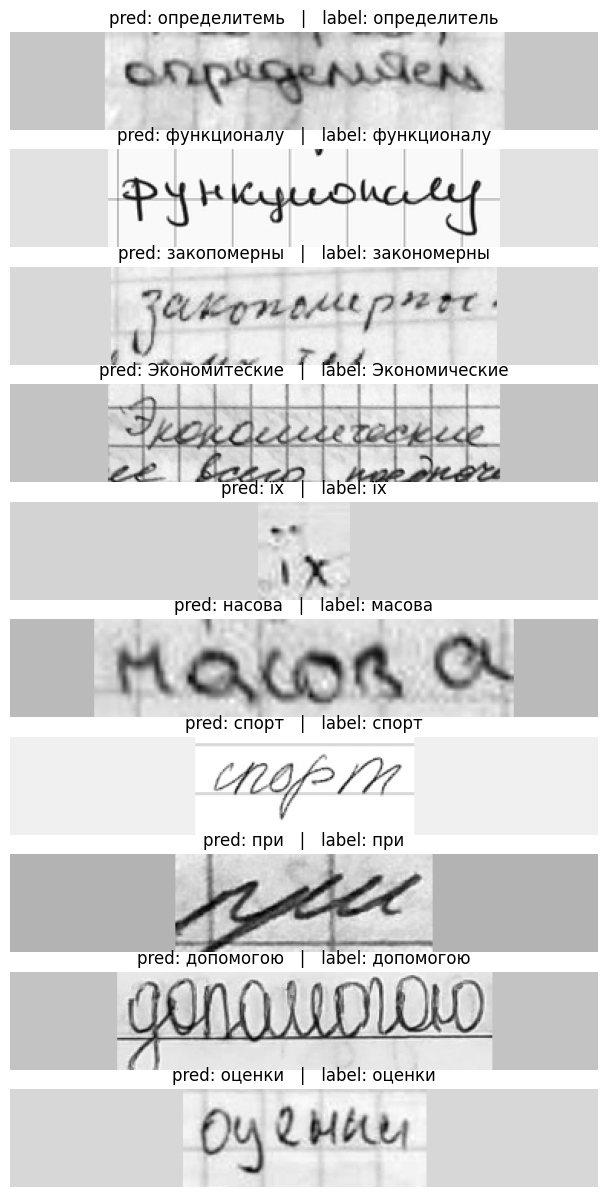

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
i = 0
for batch in validation_ds.take(10):
    if i < 2:
        i += 1
        continue
    batch_images = batch["image"]
    labels = batch["label"]
    _, ax = plt.subplots(10, 1, figsize=(15, 15))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(10):
        img = batch_images[i]
        #lbl = batch_lables[i]
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"{pred_texts[i]}"
        ax[i].imshow(img, cmap="gray")
        ax[i].set_title('pred: ' + title + '   |   label: ' + label)
        ax[i].axis("off")

plt.show()

In [49]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [48]:
#vers = []
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


In [ ]:
ds = train_ds.concatenate(validation_ds).concatenate(test_ds)


In [ ]:
hs = prediction_model.predict(ds)

/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


3065/3065 [==============================] - 95s 28ms/step


In [ ]:
max_len = 48

In [ ]:
words2 = decode_batch_predictions(hs)

In [ ]:
len(words2)

98035

In [ ]:
with open(r'del.txt', 'w') as fp:
    fp.write(' '.join(names))

In [ ]:
len(names)

98

In [ ]:
ds = train_ds.concatenate(validation_ds).concatenate(test_ds)
ds2 = train_ds2.concatenate(validation_ds2).concatenate(test_ds2)
hs = prediction_model.predict(ds)
hs2 = prediction_model.predict(ds2)

2257/3065 [=====================>........] - ETA: 21s

In [ ]:
len(words)

98035

In [ ]:
labes = []

In [ ]:
len(labes)

98035

In [ ]:
labes[0]

'по'

In [ ]:
ds = train_ds.concatenate(validation_ds).concatenate(test_ds)

In [ ]:
for batch in ds:
  labels_ = batch["label"]
  for i in range(len(labels_)):
    label = labels_[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")
    labes.append(label)

In [ ]:
with open('ds.txt', 'r') as f:
   words = f.read().split('-_-')

In [ ]:
len(words)

98035

In [ ]:
print(len(words2))

98035


In [ ]:
vrds = []
for i in range(len(lbls)):
  if levenshteinDistance(words[i], lbls[i]) > levenshteinDistance(words2[i], lbls[i]):
    vrds.append(i)

In [ ]:
len(vrds)

98

In [ ]:
names = list(map(lambda x: os.path.basename(img_paths[x]), vrds))

In [ ]:
names

['www12601.png',
 'c078a91371af0b2f.jpg',
 'www12194.png',
 'www12593.png',
 'dem12511.png',
 '0f57f3bcb5cd603d.jpg',
 'yob15358.png',
 '0a05a71d759a2c9e.jpg',
 '980e3ab475022d9d.jpg',
 'yob4934.png',
 'ahh473.png',
 'www9994.png',
 'www9997.png',
 '14191e9c56fc3c26.jpg',
 '7736afc08ca38b60.jpg',
 'dem12722.png',
 'www12108.png',
 'a20c98b95c026eb9.jpg',
 'www9477.png',
 'dem13650.png',
 'que1066.png',
 '52ad78966166c5fc.jpg',
 'www11612.png',
 'www11659.png',
 'e71d31b8872db1bd.jpg',
 'das4491.png',
 'www12628.png',
 'www12617.png',
 'e4ecc6d2209df383.jpg',
 'www12203.png',
 'www12199.png',
 'cadcdc4de61b8795.jpg',
 '324176b5815d768f.jpg',
 'yob10939.png',
 'yob11890.png',
 'e17aab60805b9291.jpg',
 'dem27083.png',
 '81e54d423378b928.jpg',
 'test160.png',
 'www12621.png',
 'd5814c2094a275cd.jpg',
 'www9501.png',
 '65ea43a442958e86.jpg',
 'cef931bda6b8ea5b.jpg',
 'dem4974.png',
 'www9646.png',
 'www10029.png',
 'www12837.png',
 'ff24ea7095bc5eb0.jpg',
 'ab3330.png',
 'yob4970.png',
 'ww

In [ ]:
for i in range(len(pred_texts)):
    #lbl = batch_lables[i]
    label = labels[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")

    if levenshteinDistance(label, pred_texts[i]) > levenshteinDistance(label, pred_texts2[i]):
          count += 1
          vers.append(id + i)
          #idxs += [(label, pred_texts[i])]
        #mass.append((label,  pred_texts[i], batch_images[i], id + i))
    id += len(pred_texts)

In [ ]:
vers = []
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
i = 0
count = 0
idxs = []
dst = validation_ds
mass = []
id = 0
test_ds


for batch, batch2 in zip(ds, ds2):
    batch_images = batch["image"]
    labels = batch["label"]

    batch_images2 = batch2["image"]
    labels2 = batch2["label"]


    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    preds2 = prediction_model.predict(batch_images2)
    pred_texts2 = decode_batch_predictions(preds2)

    for i in range(len(pred_texts)):
        #lbl = batch_lables[i]
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        if levenshteinDistance(label, pred_texts[i]) > levenshteinDistance(label, pred_texts2[i]):
          count += 1
          vers.append(id + i)
          #idxs += [(label, pred_texts[i])]
        #mass.append((label,  pred_texts[i], batch_images[i], id + i))
    id += len(pred_texts)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step


In [ ]:
print(count)
#print(idxs)

7227


In [ ]:
tst = []
for x1, x2, img, id in mass:
  if levenshteinDistance(x1, x2) >= 4:
    tst.append((x1, x2, img, id))

In [ ]:
tst[0][3]

2

In [ ]:
len(tst)

929

In [ ]:
print(tst[0][3])

2


In [ ]:
import os

In [ ]:
names = list(map(lambda x: os.path.basename(img_paths[x[3]]), tst))

In [ ]:
names

['ad13100c36616f8f.jpg',
 '8bc847e9be6ed2c6.jpg',
 'a1d96d31a2862c2e.jpg',
 '0f57fee4b4a110b5.jpg',
 'bf569f8d1a16f252.jpg',
 '7c51ed78e691e24e.jpg',
 '97a42727b0f33e55.jpg',
 '2a19f24e080e4f51.jpg',
 'd70462ab40567fa0.jpg',
 '395ee5b7194e3dd7.jpg',
 'f49d57ac026f1956.jpg',
 'bdad265e118d1851.jpg',
 '053e1dae140a7986.jpg',
 'f306803eeb25c41f.jpg',
 'd0e62e8cbbb42094.jpg',
 'b27b333f91a813c9.jpg',
 '74810dfc0ce7ea0a.jpg',
 '2d03109cceb5605f.jpg',
 '7a6ce469cb92092e.jpg',
 'edf04eaee9ace479.jpg',
 '7f43b422b2468653.jpg',
 '54fa0492b361b33c.jpg',
 '384fedbc8807f61e.jpg',
 '6525d8c5096bb080.jpg',
 'b4aac67c617a8d60.jpg',
 'ee1573f7aa5f6faf.jpg',
 'a6c8a83c0290b18c.jpg',
 'b08c0c85243111d2.jpg',
 'fc25a0d073cd12d5.jpg',
 '424005d7c3b71b96.jpg',
 '44297b5320f34a44.jpg',
 '5f674e740af719d7.jpg',
 'c98f7d2b44dc88ce.jpg',
 '58753cb86b609aa0.jpg',
 '67129a0c47b3dd29.jpg',
 '343e19abc72c0bc5.jpg',
 '2f8c1435f1341b46.jpg',
 'e7510df9560a596c.jpg',
 'a9cbafd7cb0b54f8.jpg',
 'cda2ff7248276f7f.jpg',


In [ ]:
df = pd.DataFrame({'name':names})

In [ ]:
pwd

'/content'

In [ ]:
df.to_csv('imgs.csv')

In [ ]:
img_paths[tst[i][3]]

'/content/BigDataset/data//395ee5b7194e3dd7.jpg'

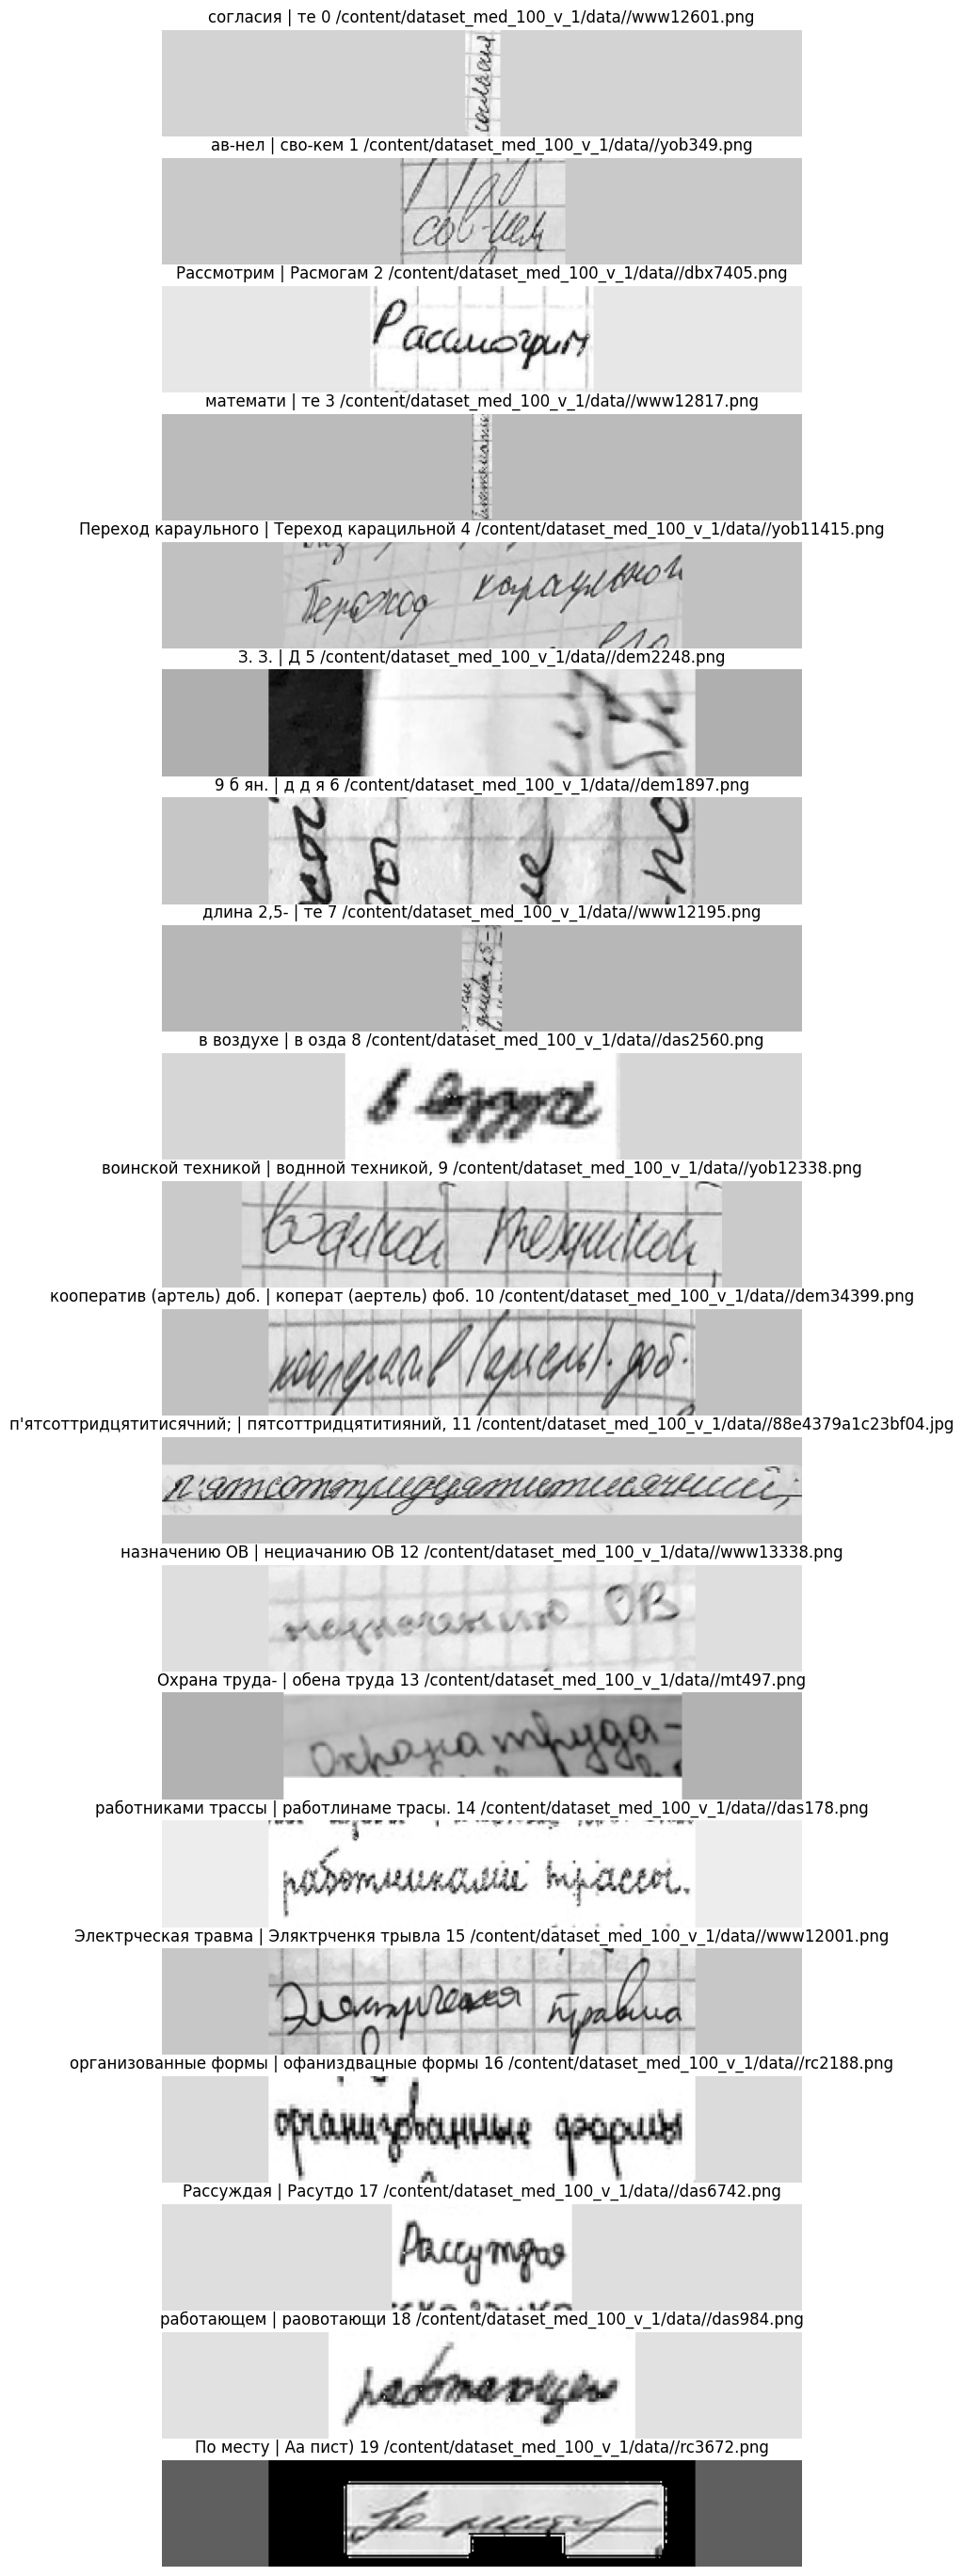

In [ ]:
_, ax = plt.subplots(20, 1, figsize=(35, 35))
for i in range(20):
  img = tf.image.flip_left_right(tst[i][2])
  img = tf.transpose(img, perm=[1, 0, 2])
  img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
  img = img[:, :, 0]

  title = f"{tst[i][0]} | {tst[i][1]} {i} {img_paths[tst[i][3]]}"
  #print(validation_img_paths[tst[i][3]])
  ax[i].imshow(img, cmap="gray")
  ax[i].set_title(title)
  ax[i].axis("off")

In [ ]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('/content/test') if isfile(join('/content/test', f))]
onlyfiles = list(map(lambda x: '/content/test/' + x, onlyfiles))

In [ ]:
256 * 1.5

384.0

In [ ]:
pr = Preprocessor((384, 64), characters)

In [ ]:
i = 0
batch_of_images = []
imgs = []
for fl in onlyfiles:
  path = fl
  img = pr.preprocess_image(path, '')
  imgs += [img]
  batch_of_images += [img]

In [ ]:
batch_of_images = tf.stack(batch_of_images)

In [ ]:
batch_of_images.shape

TensorShape([19, 384, 64, 1])

In [ ]:
transformer2 = get_transformer_model()
transformer2.load_weights('/content/drive/MyDrive/ml/trans_model_wide_v1/cp-0026.ckpt')
learning_rate = CustomSchedule(256)
opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
    #opt = keras.optimizers.Adam()
    # Compile the model and return.
transformer2.compile(optimizer=opt)
transformer2.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 384, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 384, 64, 64)  640         ['image[0][0]']                  
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 384, 64, 64)  256        ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                                                             

In [ ]:
prediction_model2 = tf.keras.models.Model(
    transformer2.get_layer(name="image").input, transformer2.get_layer(name="end_dense").output
  )
#ds = train_ds.concatenate(test_ds)
#edit_distance_callback = EditDistanceCallback(prediction_model, validation_images, validation_labels, max_len=48)

1/1 [==============================] - 0s 425ms/step


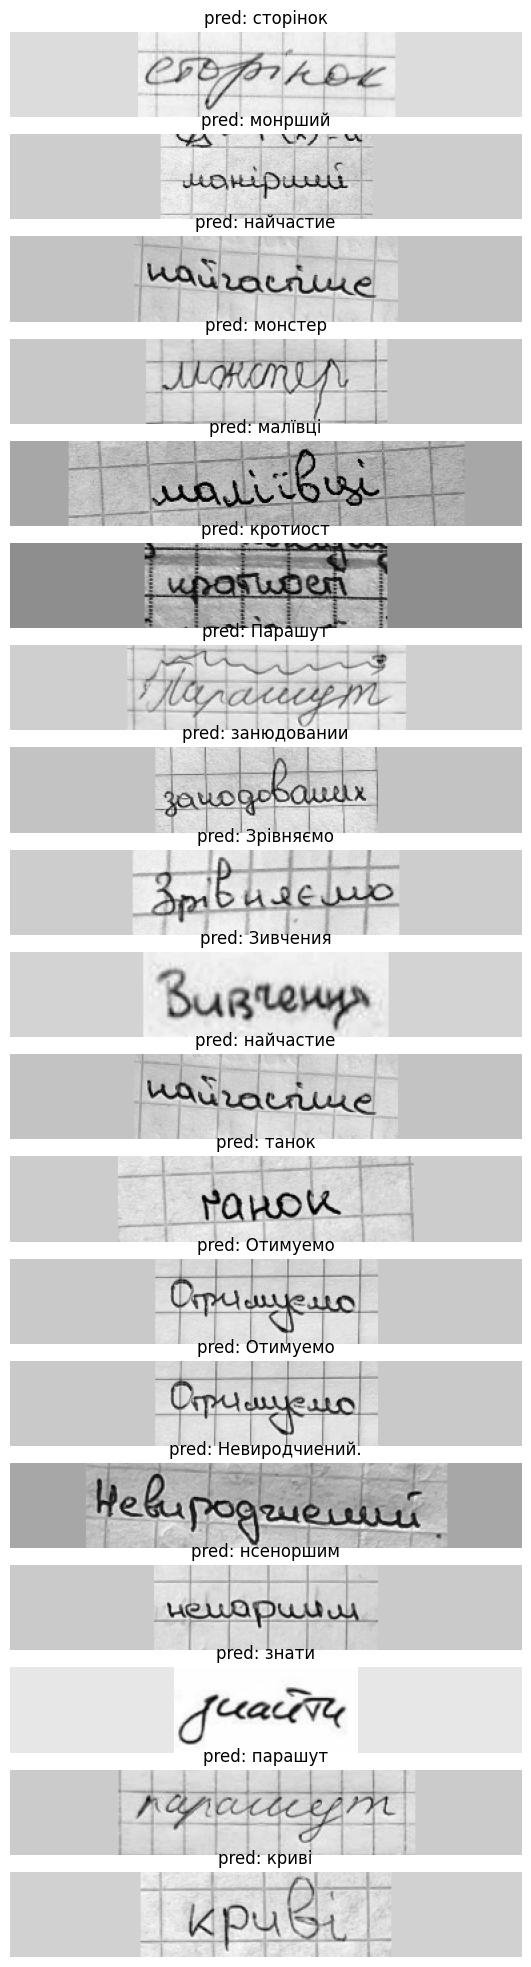

In [ ]:
 _, ax = plt.subplots(len(batch_of_images), 1, figsize=(25, 25))

preds = prediction_model2.predict(batch_of_images)
pred_texts = decode_batch_predictions(preds)

for i in range(len(batch_of_images)):
      img = batch_of_images[i]
        #lbl = batch_lables[i]
      #label = labels[i]
      #indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
      #label = tf.strings.reduce_join(num_to_char(indices))
      #label = label.numpy().decode("utf-8")

      img = tf.image.flip_left_right(img)
      img = tf.transpose(img, perm=[1, 0, 2])
      img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
      img = img[:, :, 0]

      title = f"{pred_texts[i]}"
      ax[i].imshow(img, cmap="gray")
      ax[i].set_title('pred: ' + title)
      ax[i].axis("off")

plt.show()